In [2]:
!pip install -qq duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.4 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.2.1 which is incompatible.


In [3]:
!pip install -qq voila

In [4]:
!jupyter serverextension enable --sys-prefix voila

Config option `kernel_spec_manager_class` not recognized by `EnableServerExtensionApp`.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.5.4 OK


In [5]:
!pip install -Uqq fastai

In [6]:
!pip install -Uqq fastcore

In [7]:
!pip install -Uqq fastbook

In [8]:
!pip install -qq nbdev

In [9]:
from fastbook import *
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
from duckduckgo_search import ddg_images
from time import sleep
from fastai.vision.widgets import *
import timm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
searches = 'lion', 'elephant', 'cheetah', 'leopard', 'spotted hyena', 'antelope', 'bird', 'giraffe', 'buffalo', 'wildebeest', 'zebra'
path = Path('african_wildlife')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    print(f'retrieving images of {o}')
    download_images(dest, urls=search_images_ddg(f'African {o} wildlife photo', 100))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=512, dest=path/o)

retrieving images of lion
retrieving images of elephant


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


retrieving images of cheetah
retrieving images of leopard
retrieving images of spotted hyena
retrieving images of antelope
retrieving images of bird
retrieving images of giraffe
retrieving images of buffalo
retrieving images of wildebeest
retrieving images of zebra


In [11]:
for pstring in path.ls():
    print(len(Path(pstring).ls()))

95
98
99
97
98
100
99
98
99
98
98


In [12]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

9

In [13]:
for pstring in path.ls():
    print(len(Path(pstring).ls()))

94
96
97
97
97
100
99
98
97
97
98


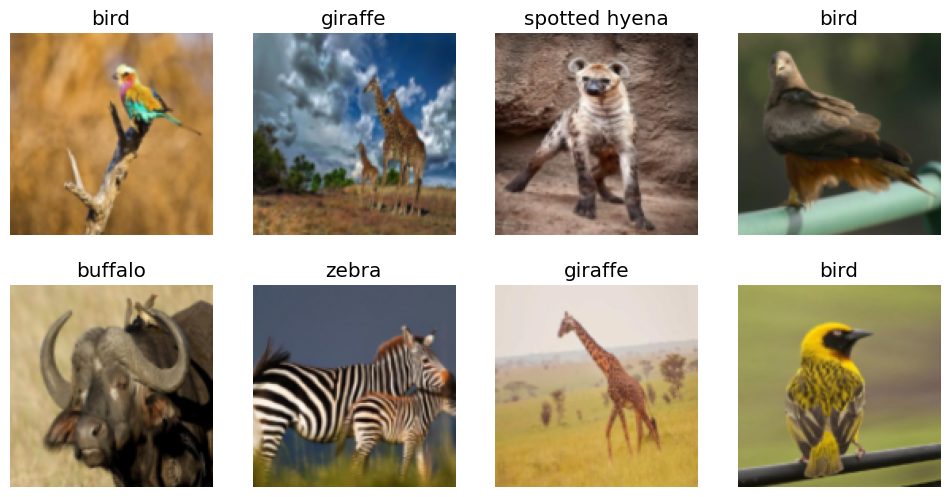

In [14]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 1999),
    get_y = parent_label,
    item_tfms = [Resize(128, method='squish')],
    batch_tfms = aug_transforms()
).dataloaders(path, bs=32)

dls.show_batch(max_n = 8)

In [15]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny']

In [16]:
learn = vision_learner(dls, 'convnextv2_tiny', metrics=error_rate).to_fp16()
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.284057,0.201925,0.051887,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.168671,0.139004,0.018868,00:11
1,0.123822,0.114415,0.028302,00:10
2,0.088352,0.110167,0.023585,00:09


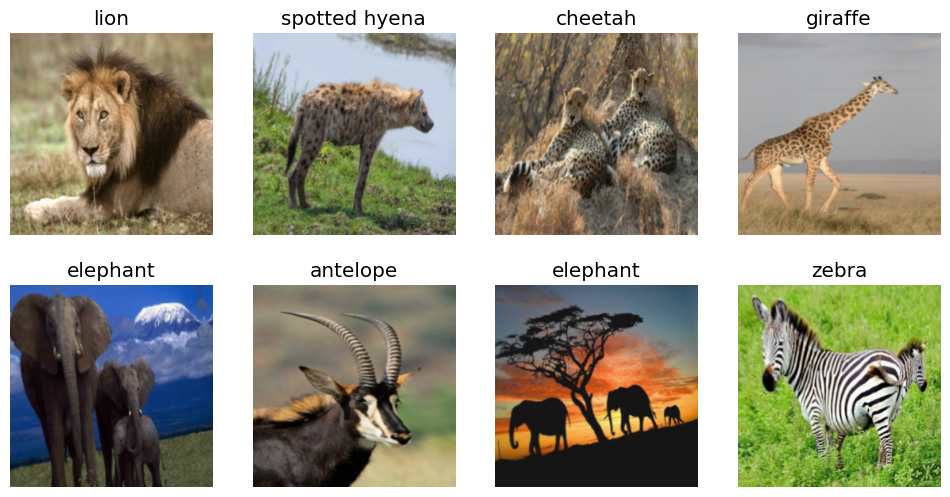

In [17]:
dls_larger_img = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 1999),
    get_y = parent_label,
    item_tfms = [Resize(256, method='squish')],
    batch_tfms = aug_transforms()
).dataloaders(path, bs=32)

dls_larger_img.show_batch(max_n = 8)

In [18]:
learn = vision_learner(dls_larger_img, 'convnextv2_tiny', metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.058724,0.020398,0.004717,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.072332,0.023012,0.009434,00:27
1,0.059914,0.010922,0.004717,00:28
2,0.047766,0.009626,0.004717,00:29


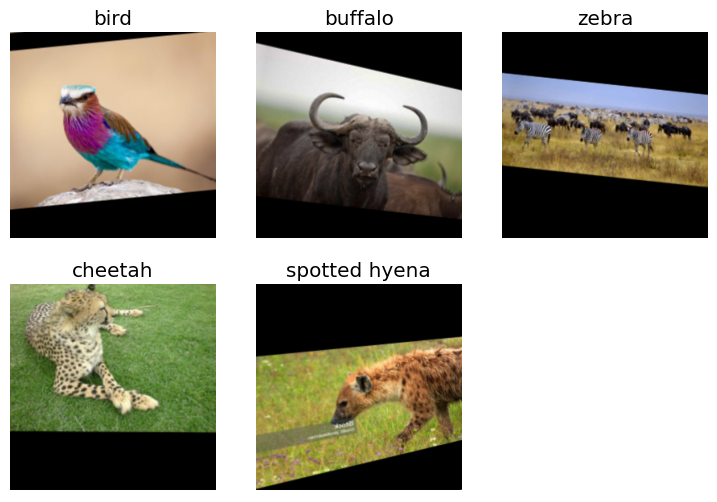

In [19]:
dls_larger_img_pad = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 1999),
    get_y = parent_label,
    item_tfms = [Resize(256, ResizeMethod.Pad, pad_mode='zeros')],
    batch_tfms = aug_transforms()
).dataloaders(path, bs=32)

dls_larger_img_pad.show_batch(max_n = 5)

In [23]:
learn = vision_learner(dls_larger_img_pad, 'convnextv2_tiny', metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.026283,0.023011,0.009434,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.110510,0.015748,0.004717,00:28
1,0.068943,0.011823,0.004717,00:28
2,0.048126,0.010554,0.000000,00:28


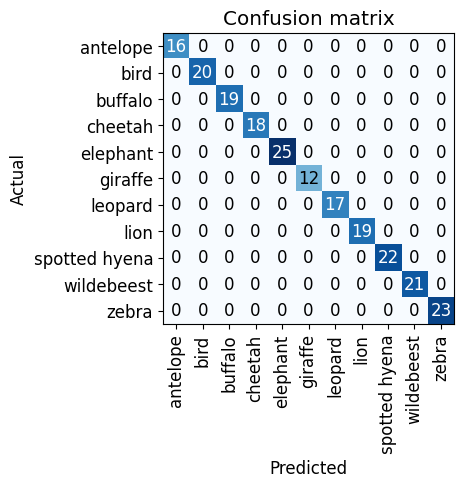

In [24]:
interpreter = ClassificationInterpretation.from_learner(learn)
interpreter.plot_confusion_matrix()

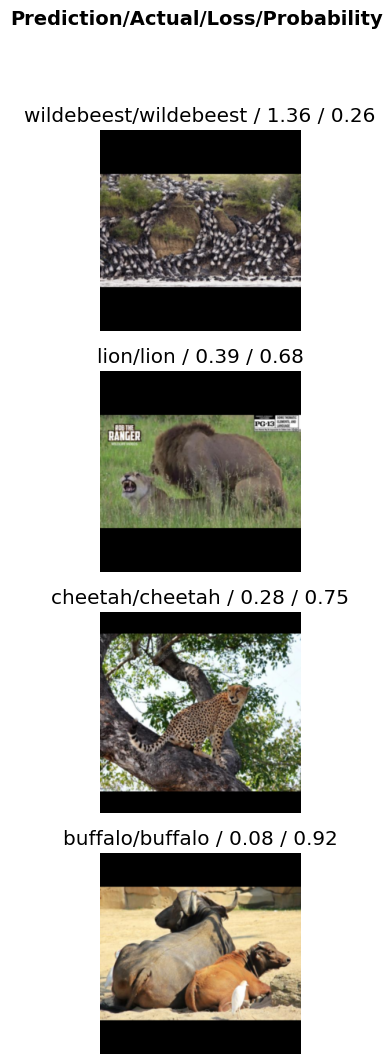

In [25]:
interpreter.plot_top_losses(4, nrows=4)

In [26]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [27]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
    
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [28]:
learn.export('convnext_923.pkl')